In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time
import time
from memory_profiler import memory_usage
import torch

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
device_idx=0
def measure_resources(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        mem_usage = memory_usage((func, args, kwargs), max_usage=True) / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        if torch.cuda.is_available():
            device = torch.device(f"cuda:{device_idx}")
            allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
            cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage:.2f} GB")
        print(f"GPU memory allocated: {allocated:.2f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")

    return wrapper

In [4]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset13_Simulation1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
adata1=adata_omics1
adata2=adata_omics2
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [5]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [6]:
k=25
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 20

In [7]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
@measure_resources
def run_pipeline(adata):

    set_seed(7)
    epochs = 200
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 160.45it/s, Epoch=199, Loss=0.8329]


Function 'run_pipeline' executed in 0.0 minutes and 1.3043 seconds.
Memory usage: 1.15 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 0.09 GB


In [11]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

In [12]:
adata

AnnData object with n_obs × n_vars = 1296 × 1100
    obs: 'truth', 'SpaLP'
    var: 'mean', 'std', 'feature_type'
    uns: 'truth_colors'
    obsm: 'spatial', 'feat', 'SpaLP'

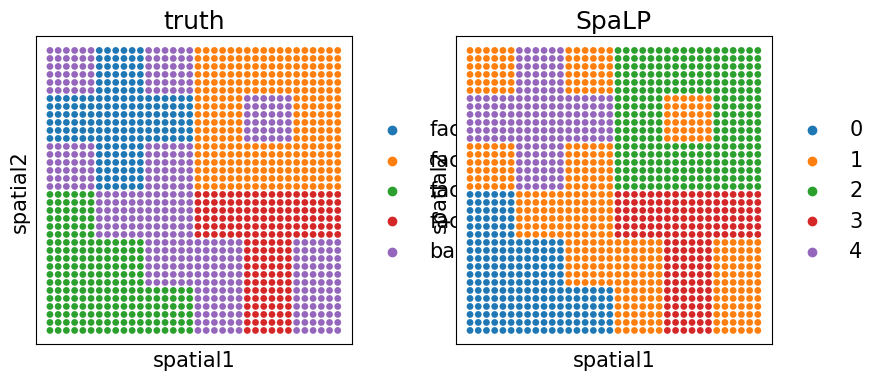

In [13]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpaLP'],size=95)

In [14]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 1.0
ARI: 1.0
NMI: 1.0
AMI: 1.0
FMI: 1.0
V-Measure: 1.0


In [15]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset14_Simulation2/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
adata1=adata_omics1
adata2=adata_omics2
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [16]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [17]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [18]:
k=25
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 20

In [19]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
@measure_resources
def run_pipeline(adata):

    set_seed(7)
    epochs = 200
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 351.82it/s, Epoch=199, Loss=0.8360]


Function 'run_pipeline' executed in 0.0 minutes and 0.6484 seconds.
Memory usage: 1.22 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 0.09 GB


In [21]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

In [22]:
adata

AnnData object with n_obs × n_vars = 1296 × 1100
    obs: 'truth', 'SpaLP'
    var: 'mean', 'std', 'feature_type'
    obsm: 'spatial', 'feat', 'SpaLP'

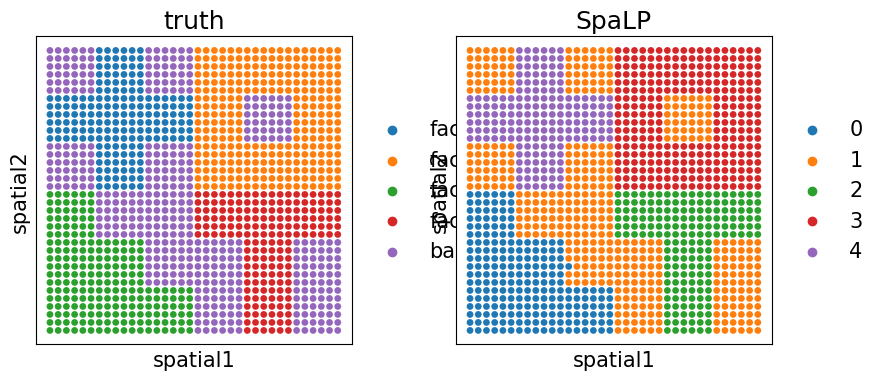

In [23]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpaLP'],size=95)

In [25]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)


print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.9977970343151755
NMI: 0.9966485198905155
AMI: 0.9966350192080351
FMI: 0.9982953437605766
V-Measure: 0.9966485198905155
Homogeneity: 0.9968198932441863


In [26]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset15_Simulation3/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
adata1=adata_omics1
adata2=adata_omics2
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [27]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [28]:
k=25
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 20

In [29]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
@measure_resources
def run_pipeline(adata):

    set_seed(7)
    epochs = 200
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 317.67it/s, Epoch=199, Loss=0.8400]


Function 'run_pipeline' executed in 0.0 minutes and 0.7185 seconds.
Memory usage: 1.24 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 0.09 GB


In [31]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

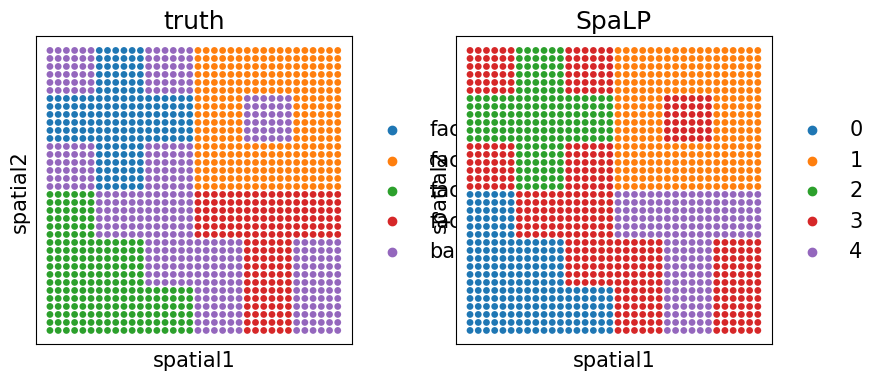

In [32]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpaLP'],size=95)

In [33]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 1.0
ARI: 1.0
NMI: 1.0
AMI: 1.0
FMI: 1.0
V-Measure: 1.0


In [5]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset16_Simulation4/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
adata1=adata_omics1
adata2=adata_omics2
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [6]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [12]:
k=25
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 20

In [13]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
@measure_resources
def run_pipeline(adata):

    set_seed(7)
    epochs = 200
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        embedding=embedding.cpu().numpy()
        adata.obsm['SpaLP']=embedding
        
run_pipeline(adata=adata)

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 332.17it/s, Epoch=199, Loss=0.8386]


Function 'run_pipeline' executed in 0.0 minutes and 0.6950 seconds.
Memory usage: 1.15 GB
GPU memory allocated: 0.02 GB
GPU memory cached: 0.09 GB


In [15]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

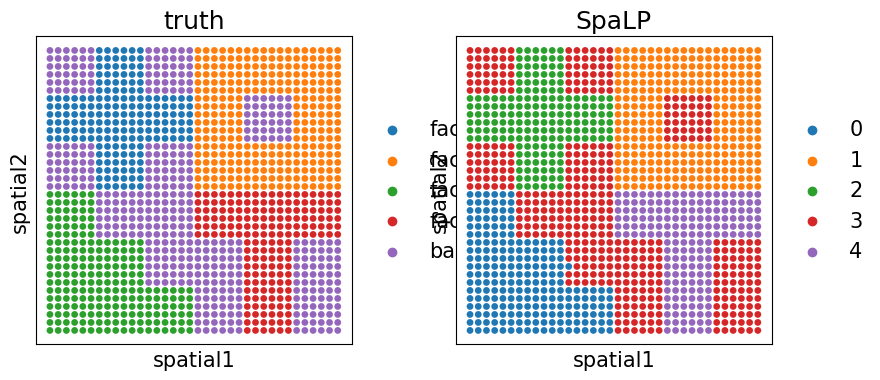

In [16]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpaLP'],size=95)

In [18]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.9977970343151755
NMI: 0.9966485198905155
AMI: 0.9966350192080351
FMI: 0.9982953437605766
V-Measure: 0.9966485198905155
Homogeneity: 0.9968198932441863


In [53]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset17_Simulation5/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
adata1=adata_omics1
adata2=adata_omics2
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X
sc.pp.scale(adata2)
adata2.obsm['feat']=adata2.X

In [54]:
adata=sc.AnnData(np.hstack([adata1.obsm['feat'],adata2.obsm['feat']]))
sc.pp.scale(adata)
adata.var_names = adata1.var_names.tolist() + adata2.var_names.tolist()
rna_len = adata1.var_names.shape[0]
prot_len = adata2.var_names.shape[0]
adata.var['feature_type'] = ['RNA'] * rna_len + ['Protein'] * prot_len
adata.obs_names=adata2.obs_names
adata.obsm['spatial']=adata2.obsm['spatial']
adata.obsm['feat']=adata.X
adata.obs['truth']=adata_omics2.obs['truth']

In [69]:
k=25
graph = prepare_inputs(adata, k, device)
in_channels = graph.features.shape[1]  
out_channels = 20

In [70]:
model = SpatialLocalPooling(in_channels, out_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
set_seed(7)
epochs = 250
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 318.13it/s, Epoch=249, Loss=0.8315]


In [72]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [73]:
adata.obsm['SpaLP']=embedding

In [74]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['SpaLP']=labels.astype(str)

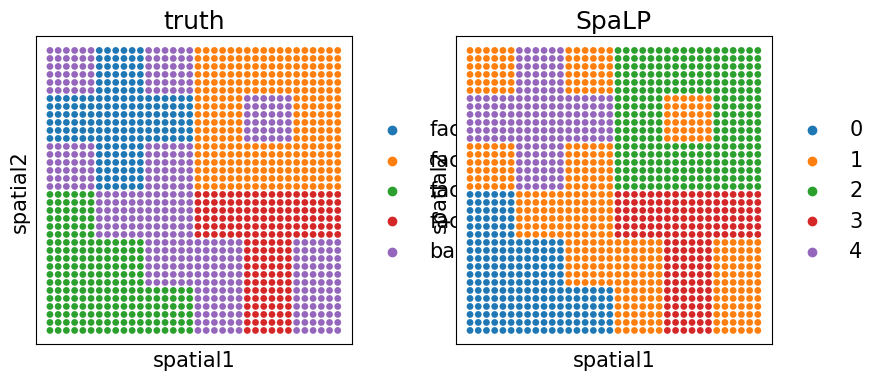

In [75]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpaLP'],size=95)

In [76]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpaLP'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)

Homogeneity: 1.0
ARI: 1.0
NMI: 1.0
AMI: 1.0
FMI: 1.0
V-Measure: 1.0
